In [1]:
# import pylab as plt
import sys
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
from PIL import Image
np.set_printoptions(threshold=sys.maxsize)
# np.set_printoptions(threshold=np.inf)
from matplotlib.path import Path
import cv2

Image: ../../assets/images/visual_control/Sim1_06.png


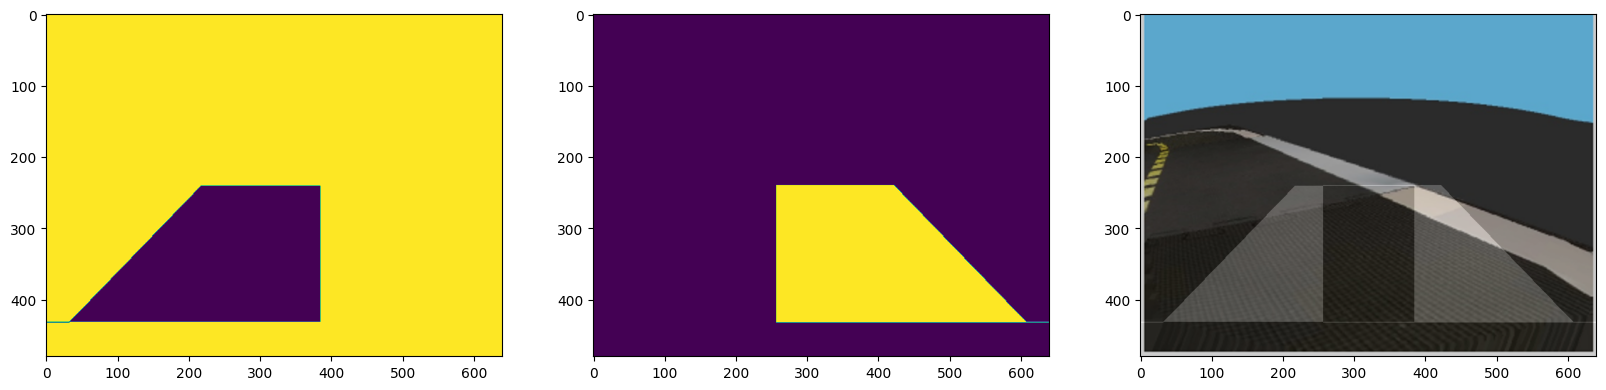

In [44]:
def get_symmetry(P, W):
    Q = []
    for (x,y) in P:
        Q.append((x,W-y))
    return Q

height, width = 480,640
# height, width = 14,20

x, y = np.mgrid[:height, :width]
coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) 

# Duckiebot (start bottom-left corner, going CW)
# p1 = [  (1.0*height, 0.07*width), 
#         (0.45*height, 0.45*width), 
#         (0.45*height, 0.5*width), 
#         (1*height, 0.5*width), 
#         (1*height, 0.02*width)] 

# Simulation 
p1 = [  (0.9*height, 0.05*width), 
        (0.5*height, 0.34*width), 
        (0.5*height, 0.6*width), 
        (0.9*height, 0.6*width), 
        (0.9*height, 0.0*width)] 
mask_Left = Path(p1).contains_points(coors) * -1

# Zone2: symmetric to zone1
p2 = get_symmetry(p1, width)
mask_Right = Path(p2).contains_points(coors) * 1


# Read image
# im = '../../assets/images/visual_control/pic1_rect.png'  # straight
# im = '../../assets/images/visual_control/pic2_rect.png'  # bot angled slightly left 
# im = '../../assets/images/visual_control/pic3_rect.png'  # bot angled slightly right
# im = '../../assets/images/visual_control/pic10.png'      # bot slightly located on right  
# im = '../../assets/images/visual_control/pic11.png'    # bot angled left, must turn right
# im = '../../assets/images/visual_control/pic12.png'      # bot angled right, must turn left
im = '../../assets/images/visual_control/Sim1_06.png'
# im = '../../assets/images/visual_control/Sim2_01.png'

print(f"Image: {im}")
I = Image.open(im).convert('RGBA').resize((width,height))

# Create blended mask+image
mymask = (mask_Left+mask_Right).astype(int).copy().reshape(height, width)
mymask[mymask != 0] = 1
M = Image.fromarray(np.uint8(mymask*255)).convert('RGBA')
B = Image.blend(I, M, alpha=.2)

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,8))
ax1.imshow(mask_Left.reshape(height, width), aspect = 1)
ax2.imshow(mask_Right.reshape(height, width), aspect = 1)
ax3.imshow(B, aspect = 1)
plt.show()


In [3]:
# Read image
im = '../../assets/images/visual_control/pic1_rect.png'  # straight
imgbgr = cv2.imread(im)

# Image processing
imgrgb = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB) # RGB version for the sake of visualization
imghsv = cv2.cvtColor(imgrgb, cv2.COLOR_BGR2HSV)# Convert the image to HSV for any color-based filtering
imggray = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2GRAY) #  grayscale version

# Smooth the image using a Gaussian kernel
sigma = 3
img_gaussian_filter = cv2.GaussianBlur(imggray,(0,0), sigma)

# Horizon mask
mask_ground = np.zeros_like(imggray, dtype=np.uint8) # TODO: CHANGE ME
mask_ground[200:,:] = 1
print("mask_ground",mask_ground.shape)

# Convolve the image with the Sobel operator (filter) to compute the numerical derivatives in the x and y directions
sobelx = cv2.Sobel(img_gaussian_filter,cv2.CV_64F,1,0)
sobely = cv2.Sobel(img_gaussian_filter,cv2.CV_64F,0,1)

# Compute the magnitude of the gradients
Gmag = np.sqrt(sobelx*sobelx + sobely*sobely)

# Apply threshold to gradients magnitude
threshold = 15
mask_mag = (Gmag > threshold)
print("mask_mag: ",mask_mag.shape)


# White and yellow HSV thresholds
white_lower_hsv = np.array([0, 0, 130]) 
white_upper_hsv = np.array([179, 40, 255]) 
yellow_lower_hsv = np.array([16, 114, 107]) 
yellow_upper_hsv = np.array([30, 255, 255])

# Define mask for 1st image
mask_white = cv2.inRange(imghsv, white_lower_hsv, white_upper_hsv)
mask_yellow = cv2.inRange(imghsv, yellow_lower_hsv, yellow_upper_hsv) 
print("mask_white",mask_white.shape)
print("mask_yellow",mask_yellow.shape)
    
# masks for the left- and right-halves of the image
width = imggray.shape[1]
mask_left = np.ones(sobelx.shape)
mask_left[:,int(np.floor(width/2)):width + 1] = 0
mask_right = np.ones(sobelx.shape)
mask_right[:,0:int(np.floor(width/2))] = 0

print("mask_right: ",mask_right.shape)
print("mask_left: ",mask_left.shape)

# Generate a mask that identifies pixels based on the sign of their x-derivative
mask_sobelx_pos = (sobelx > 0)
mask_sobelx_neg = (sobelx < 0)
mask_sobely_pos = (sobely > 0)
mask_sobely_neg = (sobely < 0)
print("mask_sobelx_neg:",mask_sobelx_neg.shape)

# masks with the gradient magnitude mask and color-based
mask_left_edge = mask_ground * mask_left * mask_mag * mask_sobelx_neg * mask_sobely_neg * mask_yellow
mask_right_edge = mask_ground * mask_right * mask_mag * mask_sobelx_pos * mask_sobely_neg * mask_white


mask_ground (480, 640)
mask_mag:  (480, 640)
mask_white (480, 640)
mask_yellow (480, 640)
mask_right:  (480, 640)
mask_left:  (480, 640)
mask_sobelx_neg: (480, 640)


In [41]:
mask_ground.shape

(480, 640, 3)